In [1]:
import sys
sys.path.append('../src')

In [2]:
from data.ingestion import load_car_sales_data
from data.preparation import generate_datasets
from evaluation.key_performance_indicators import kpi_ml
import pandas as pd

In [3]:
# Load car sales data
car_sales_df = load_car_sales_data("../data/norway_new_car_sales_by_make.csv")
# Generate datasets
X_train, y_train, X_test, y_test = generate_datasets(
    df=car_sales_df,
    x_length=12,
    y_length=1,
    test_loops=12
)

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
forest = RandomForestRegressor(
    bootstrap=True,
    max_samples=0.95,
    max_features=11,
    min_samples_leaf=18,
    max_depth=7,
)
forest.fit(X=X_train, y=y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,18
,min_weight_fraction_leaf,0.0
,max_features,11
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [6]:
y_train_pred = forest.predict(X=X_train)
y_test_pred = forest.predict(X=X_test)

kpi_ml(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    name="Random Forest Regressor"
)

                          MAE  RMSE  BIAS
Random Forest Regressor                  
Train                    15.7  40.0   0.0
Test                     18.4  47.3   3.8


In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [8]:
# Hyperparameter optimization for Random Forest Regressor
max_depth = list(range(5, 11)) + [None]
min_samples_split = list(range(5, 20))
min_samples_leaf = list(range(2, 15))
max_features = list(range(3, 8))
bootstrap = [True]
max_samples = [0.7, 0.8, 0.9, 0.95, 1.0]

param_dist = {
    "max_depth": max_depth[-3:],
    "min_samples_split": min_samples_split[:10],
    "min_samples_leaf": min_samples_leaf[:5],
    "max_features": max_features,
    "bootstrap": bootstrap,
    "max_samples": max_samples,
}

In [9]:
forest = RandomForestRegressor(n_jobs=1, n_estimators=200)
random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    n_jobs=-1,
    cv=TimeSeriesSplit(n_splits=5),
    verbose=1,
    n_iter=100,  # 400
    scoring="neg_mean_absolute_error",
)
random_search.fit(X=X_train, y=y_train)
print("Best parameters found: ", random_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'min_samples_split': 12, 'min_samples_leaf': 3, 'max_samples': 0.95, 'max_features': 5, 'max_depth': 9, 'bootstrap': True}


In [10]:
y_train_pred = random_search.predict(X=X_train)
y_test_pred = random_search.predict(X=X_test)
kpi_ml(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    name="Random Forest Regressor with Random Search"
)

                                             MAE  RMSE  BIAS
Random Forest Regressor with Random Search                  
Train                                       12.9  32.0  -0.1
Test                                        17.4  44.9   2.3


<Axes: >

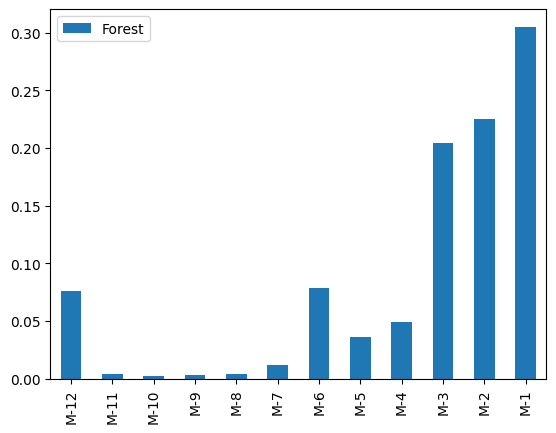

In [11]:
# Feature importance for Random Forest Regressor
forest: RandomForestRegressor = random_search.best_estimator_
cols = X_train.shape[1]
features = [f"M-{cols - col}" for col in range(cols)]
data = forest.feature_importances_.reshape(-1, 1)
feature_importance_df = pd.DataFrame(
    data=data,
    index=features,
    columns=["Forest"]
)
feature_importance_df.plot(kind="bar")